In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from acquire import get_curriculum_data

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = get_curriculum_data()
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900223 entries, 0 to 900222
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   ip          900223 non-null  object 
 5   name        847330 non-null  object 
 6   start_date  847330 non-null  object 
 7   end_date    847330 non-null  object 
 8   program_id  847330 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 68.7+ MB


,date,time,path,user_id,ip,name,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0


##### 1 - Drop single Nan record (raw df: index # 506304)

In [4]:
df = df.drop(df.index[506305])
df.shape

(900222, 9)

##### 2 - Drop all program_id == 4  (5 records)

In [5]:
df = df[df.program_id != 4]
df.shape

(900217, 9)

##### 3 - Split up the path to drill down to units, lessons and beyond

First, user a new dataframe to create the following:

In [6]:
splits = df.path.str.split('/', expand=True)
splits.head()

,0,1,2,3,4,5,6,7
0,,,None,None,None,None,None,None
1,java-ii,None,None,None,None,None,None,None
2,java-ii,object-oriented-programming,None,None,None,None,None,None
3,slides,object_oriented_programming,None,None,None,None,None,None
4,javascript-i,conditionals,None,None,None,None,None,None


Now create a column telling how many rows there are

In [140]:
# Create a column that indicates how many columns of data that row of splits has
splits['row_type'] = 8 - (splits.isnull().sum(axis=1))


In [8]:
#Unit is the highest level
splits['unit'] = splits[0]

In [9]:
# Subunit, sometimes found in second row
splits['subunit'] = np.where(splits.row_type > 2, splits[1],splits[7])

In [10]:
# Next, lesson, which is in the first or third row
splits['lesson'] = np.where(splits.row_type == 2, splits[1], splits[2])

In [12]:
# And finally, the rest of the path
splits['other'] = np.where(splits.row_type ==8,
                           splits[3] + '/' + splits[4] + '/' + splits[5] + '/' + splits[6] + '/' + splits[7],
                           np.where(splits.row_type == 7, 
                               splits[3] + '/' + splits[4] + '/' + splits[5] + '/' + splits[6],
                               np.where(splits.row_type == 6,
                                        splits[3] + '/' + splits[4] + '/' + splits[5],
                                        np.where(splits.row_type == 5,
                                                 splits[3] + '/' + splits[4], splits[3]))))

In [13]:
splits.head(2)

,0,1,2,3,4,5,6,7,row_type,unit,subunit,lesson,other
0,,,None,None,None,None,None,None,2,,None,,None
1,java-ii,None,None,None,None,None,None,None,1,java-ii,None,None,None


In [14]:
splits = splits[['unit','subunit','lesson','other']]

In [15]:
splits.sample(2)

,unit,subunit,lesson,other
57571,java-ii,None,arrays,None
375833,javascript-i,None,bom-and-dom,None


##### Merge with original dataframe

In [16]:
df = df.merge(splits, left_index=True, right_index = True)
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900217 entries, 0 to 900222
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900217 non-null  object 
 1   time        900217 non-null  object 
 2   path        900217 non-null  object 
 3   user_id     900217 non-null  int64  
 4   ip          900217 non-null  object 
 5   name        847324 non-null  object 
 6   start_date  847324 non-null  object 
 7   end_date    847324 non-null  object 
 8   program_id  847324 non-null  float64
 9   unit        900217 non-null  object 
 10  subunit     226868 non-null  object 
 11  lesson      731929 non-null  object 
 12  other       26308 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 128.4+ MB


,date,time,path,user_id,ip,name,start_date,end_date,program_id,unit,subunit,lesson,other
6643,2018-02-07,10:22:58,javascript-i/arrays/manipulating,30,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,arrays,manipulating,None
838144,2021-03-07,13:21:55,classification/evaluation,485,173.174.142.84,Bayes,2019-08-19,2020-01-30,3.0,classification,None,evaluation,None
847377,2021-03-15,16:59:57,/,923,173.174.231.66,Neptune,2021-03-15,2021-09-03,2.0,,None,,None
295154,2019-07-09,21:41:32,html-css/introduction,51,72.179.161.39,Kings,2016-05-23,2016-09-15,1.0,html-css,None,introduction,None
259385,2019-05-05,20:52:23,/,367,216.177.165.194,NaN,NaN,NaN,NaN,,None,,None


##### 3 - Remove all those whose name/cohort are 'Staff' and set them aside in seperate dataframe.

In [17]:
df_staff = df[df.name == 'Staff']
df_staff.info()
df_staff.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84031 entries, 166284 to 900222
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        84031 non-null  object 
 1   time        84031 non-null  object 
 2   path        84031 non-null  object 
 3   user_id     84031 non-null  int64  
 4   ip          84031 non-null  object 
 5   name        84031 non-null  object 
 6   start_date  84031 non-null  object 
 7   end_date    84031 non-null  object 
 8   program_id  84031 non-null  float64
 9   unit        84031 non-null  object 
 10  subunit     16141 non-null  object 
 11  lesson      66112 non-null  object 
 12  other       2185 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 9.0+ MB


,date,time,path,user_id,ip,name,start_date,end_date,program_id,unit,subunit,lesson,other
166284,2018-12-06,14:15:29,appendix/further-reading/java/intellij-tomcat-...,53,97.105.19.58,Staff,2014-02-04,2014-02-04,2.0,appendix,further-reading,java,intellij-tomcat-configuration
166294,2018-12-06,14:25:40,javascript-i,314,97.105.19.58,Staff,2014-02-04,2014-02-04,2.0,javascript-i,None,None,None
166295,2018-12-06,14:25:41,javascript-i/coffee-project,314,97.105.19.58,Staff,2014-02-04,2014-02-04,2.0,javascript-i,None,coffee-project,None
166521,2018-12-06,15:31:29,spring,40,170.248.173.247,Staff,2014-02-04,2014-02-04,2.0,spring,None,None,None
166522,2018-12-06,15:31:33,spring/fundamentals/security,40,170.248.173.247,Staff,2014-02-04,2014-02-04,2.0,spring,fundamentals,security,None


In [18]:
df = df[df.name != 'Staff']
df.shape

(816186, 13)

##### 4 - Impute User Cohorts

This is a good time to create the lists for each program_id, noting Web Dev = concatintating those two lists:

In [19]:
web_dev_1 = df[df.program_id == 1].name.unique()
web_dev_2 = df[df.program_id == 2].name.unique()
data_science = df[df.program_id == 3].name.unique()
print(f'web_dev_1 cohorts:{len(web_dev_1)}, web_dev_2 cohorts:{len(web_dev_2)}, data_science cohorts:{len(data_science)}')
print(f'Total = {len(web_dev_1) + len(web_dev_2) + len(data_science)} cohorts')

web_dev_1 cohorts:13, web_dev_2 cohorts:27, data_science cohorts:5
Total = 45 cohorts


### Make a dataframe with cohort, low user id and high user id

First make a list of all cohorts

In [20]:
cohort_list = df.name.unique()

Now make a dataframe of just those in cohorts

In [21]:
has_cohort = df[df['name'].isnull() != True]

Make a dataframe with the ranges of user_ids for each cohort

In [22]:
cohort_ranges= []
for cohort in cohort_list:
    entry = {}
    entry['Cohort'] = cohort
    entry['Low user_id'] = has_cohort[has_cohort.name == cohort].user_id.min()
    entry['High user_id'] = has_cohort[has_cohort.name == cohort].user_id.max()
    cohort_ranges.append(entry)
pd.DataFrame(cohort_ranges)

,Cohort,Low user_id,High user_id
0,Hampton,1.0,646.0
1,Teddy,2.0,459.0
2,Sequoia,10.0,346.0
3,Arches,11.0,402.0
4,Niagara,21.0,322.0
5,Pinnacles,26.0,611.0
6,Quincy,37.0,610.0
7,NaN,NaN,NaN
8,Kings,50.0,318.0
9,Lassen,53.0,852.0


### *This led to me to want to look at boxplots of cohort as x vs user_ids on left.  Will use only those from has_cohort*

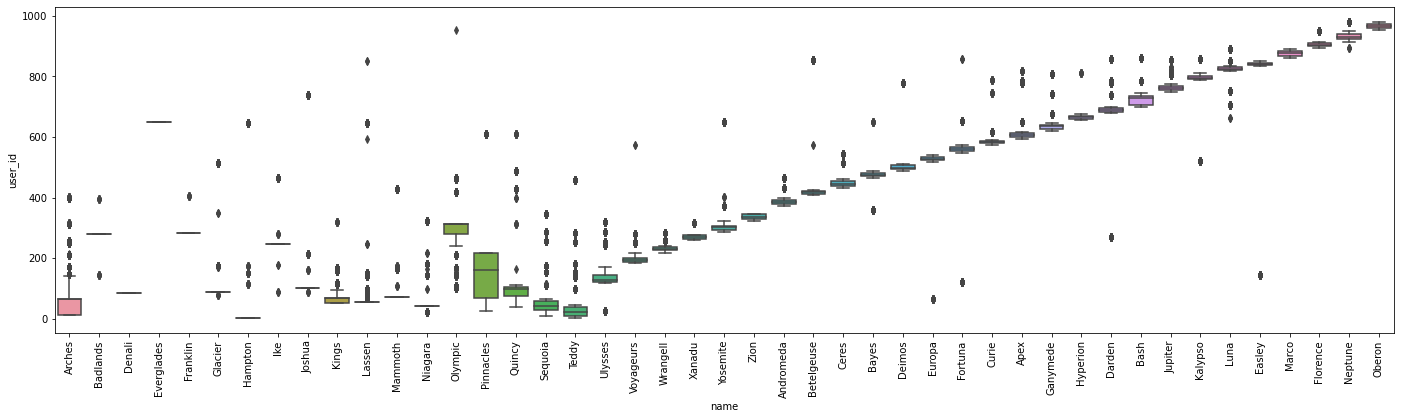

In [23]:
plt.figure(figsize = (24,6))
sns.boxplot(data = has_cohort.sort_values('start_date'), x = 'name', y = 'user_id')
plt.xticks(rotation = 90)
plt.show()

## Well that seems to indicate there are outliers in virtually every cohort.  Good to know - this is a great #8 question and answer!

Going back to the cohort imputation:

Creating a dataframe for all user_ids without a cohort.

In [24]:
no_cohort = df[df['name'].isnull()  == True]
no_cohort

,date,time,path,user_id,ip,name,start_date,end_date,program_id,unit,subunit,lesson,other
411,2018-01-26,16:46:16,/,48,97.105.19.61,NaN,NaN,NaN,NaN,,None,,None
412,2018-01-26,16:46:24,spring/extra-features/form-validation,48,97.105.19.61,NaN,NaN,NaN,NaN,spring,extra-features,form-validation,None
425,2018-01-26,17:54:24,/,48,97.105.19.61,NaN,NaN,NaN,NaN,,None,,None
435,2018-01-26,18:32:03,/,48,97.105.19.61,NaN,NaN,NaN,NaN,,None,,None
436,2018-01-26,18:32:17,mysql/relationships/joins,48,97.105.19.61,NaN,NaN,NaN,NaN,mysql,relationships,joins,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
899897,2021-04-21,12:49:00,javascript-ii,717,136.50.102.126,NaN,NaN,NaN,NaN,javascript-ii,None,None,None
899898,2021-04-21,12:49:02,javascript-ii/es6,717,136.50.102.126,NaN,NaN,NaN,NaN,javascript-ii,None,es6,None
899899,2021-04-21,12:51:27,javascript-ii/map-filter-reduce,717,136.50.102.126,NaN,NaN,NaN,NaN,javascript-ii,None,map-filter-reduce,None
899900,2021-04-21,12:52:37,javascript-ii/promises,717,136.50.102.126,NaN,NaN,NaN,NaN,javascript-ii,None,promises,None


In [25]:
# Let's get a list of all user_ids without cohort name
no_cohort_list = no_cohort.user_id.unique()
no_cohort_list

array([ 48,  54,  58,  59,  61,  62,  63,  73,  74,  78,  79,  86,  88,
        89, 100, 103, 111, 137, 166, 176, 213, 247, 317, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 372, 375, 403, 406, 429, 544,  64, 713,
       714, 715, 716, 717, 718, 663, 719, 720, 721, 722, 723, 724, 725,
       726, 727, 728, 729, 346, 731, 736, 644, 744, 782, 810, 814, 815])

Now we have to copy of the main df dataframe replacing nulls with 'X'

In [26]:
df_X = df.copy()
df_X['name'] = np.where(df_X.name.isnull() == True, 'X',df_X.name)
df_X

,date,time,path,user_id,ip,name,start_date,end_date,program_id,unit,subunit,lesson,other
0,2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,,None,,None
1,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,None,None,None
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,None,object-oriented-programming,None
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,slides,None,object_oriented_programming,None
4,2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,None,conditionals,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
900210,2021-04-21,16:36:09,jquery/personal-site,869,136.50.98.51,Marco,2021-01-25,2021-07-19,2.0,jquery,None,personal-site,None
900211,2021-04-21,16:36:34,html-css/css-ii/bootstrap-grid-system,948,104.48.214.211,Neptune,2021-03-15,2021-09-03,2.0,html-css,css-ii,bootstrap-grid-system,None
900212,2021-04-21,16:37:48,java-iii,834,67.11.50.23,Luna,2020-12-07,2021-06-08,2.0,java-iii,None,None,None
900213,2021-04-21,16:38:14,java-iii/servlets,834,67.11.50.23,Luna,2020-12-07,2021-06-08,2.0,java-iii,None,servlets,None


In [27]:
user_list = []

#loop over each, skipping over 'problem' user_ids 
for user in no_cohort_list:
    inlist = {}
    inlist['prev_user_cohort'] = df_X[df_X.user_id == (user-1)].name.max()
    inlist['prev_user_program'] = df_X[df_X.user_id == (user-1)].program_id.max()
    inlist['user_id'] = user
    inlist['next_user_cohort'] = df_X[df_X.user_id == (user+1)].name.max()
    inlist['next_user_program'] = df_X[df_X.user_id == (user+1)].program_id.max()
    inlist['total_accesses'] = df_X[df_X.user_id == user].date.count()
    user_list.append(inlist)
df_no_cohort_user = pd.DataFrame(user_list).set_index('user_id')
df_no_cohort_user

,prev_user_cohort,prev_user_program,next_user_cohort,next_user_program,total_accesses
user_id,,,,,
48,Sequoia,2.0,Sequoia,2.0,1581
54,Lassen,1.0,Sequoia,2.0,146
58,Sequoia,2.0,X,NaN,462
59,X,NaN,Arches,1.0,42
61,Arches,1.0,X,NaN,816
...,...,...,...,...,...
744,Bash,2.0,NaN,NaN,69
782,Darden,3.0,Darden,3.0,370
810,Ganymede,2.0,Kalypso,2.0,709


Now that we have this, we can get suggested cohorts - that is cohorts who are surrounded by others.

In [108]:
df_no_cohort_user['suggested_cohort'] = np.where(df_no_cohort_user.prev_user_cohort != df_no_cohort_user.next_user_cohort,'Cannot Impute',
                                                np.where(df_no_cohort_user.prev_user_cohort == 'X', 'Cannot Impute' ,df_no_cohort_user.prev_user_cohort)) 
suggested_imputes = df_no_cohort_user[df_no_cohort_user.suggested_column != 'Cannot Impute']
suggested_imputes = suggested_imputes[['suggested_cohort','prev_user_program']].rename(columns = {'suggested_cohort':'name','prev_user_program':'program_id'})

In [135]:
suggested_imputes

,name,program_id
user_id,,
48,Sequoia,2.0
375,Andromeda,2.0
663,Hyperion,2.0
346,Zion,2.0
731,Bash,2.0
736,Bash,2.0
644,Ganymede,2.0
782,Darden,3.0


In [139]:
suggested_imputes.merge(cohort_info, how='left', on='name')

,name,program_id_x,index,start_date,end_date,program_id_y
0,Sequoia,2.0,37,2017-09-27,2018-02-15,2.0
1,Andromeda,2.0,0,2019-03-18,2019-07-30,2.0
2,Hyperion,2.0,21,2020-05-26,2020-11-10,2.0
3,Zion,2.0,44,2019-01-22,2019-06-04,2.0
4,Bash,2.0,4,2020-07-20,2021-01-21,2.0
5,Bash,2.0,4,2020-07-20,2021-01-21,2.0
6,Ganymede,2.0,18,2020-03-23,2020-08-20,2.0
7,Darden,3.0,9,2020-07-13,2021-01-12,3.0


##### USE THIS DATAFRAME TO INPUTE ON THE MAIN DF

Quick check on imputation (these should all have their respective programs type units)

In [110]:
for user in suggested_imputes.index:
    print('User ID:',user)
    print(df[df.user_id == user].unit.value_counts().head())
    print('\n-----\n')

User ID: 48
javascript-i    247
spring          185
mysql           172
java-ii         162
html-css        155
Name: unit, dtype: int64

-----

User ID: 375
spring          245
mysql           185
html-css        184
javascript-i    171
java-iii        166
Name: unit, dtype: int64

-----

User ID: 663
html-css        172
javascript-i     48
examples         27
                 21
toc              20
Name: unit, dtype: int64

-----

User ID: 346
html-css        520
toc             466
javascript-i    458
                283
jquery          217
Name: unit, dtype: int64

-----

User ID: 731
html-css        177
javascript-i    143
toc              88
                 62
examples         41
Name: unit, dtype: int64

-----

User ID: 736
javascript-i    350
spring          349
html-css        337
                193
mysql           192
Name: unit, dtype: int64

-----

User ID: 644
java-iii        245
mysql           221
html-css        220
javascript-i    191
search          173
Name: unit, 

##### All of these check out with the type of program their cohort represents, so feel ok putting them into the main dataframe.

In [133]:
for n in suggested_imputes.index[0:1]:
    df[df.user_id == n].name = suggested_imputes[suggested_imputes.index == n].name
df[df.user_id == 48]

,date,time,path,user_id,ip,name,start_date,end_date,program_id,unit,subunit,lesson,other
411,2018-01-26,16:46:16,/,48,97.105.19.61,NaN,NaN,NaN,NaN,,None,,None
412,2018-01-26,16:46:24,spring/extra-features/form-validation,48,97.105.19.61,NaN,NaN,NaN,NaN,spring,extra-features,form-validation,None
425,2018-01-26,17:54:24,/,48,97.105.19.61,NaN,NaN,NaN,NaN,,None,,None
435,2018-01-26,18:32:03,/,48,97.105.19.61,NaN,NaN,NaN,NaN,,None,,None
436,2018-01-26,18:32:17,mysql/relationships/joins,48,97.105.19.61,NaN,NaN,NaN,NaN,mysql,relationships,joins,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
507287,2020-04-08,16:42:09,javascript-i/introduction/primitive-types,48,216.177.189.26,NaN,NaN,NaN,NaN,javascript-i,introduction,primitive-types,None
555480,2020-05-28,10:14:25,/,48,216.177.189.26,NaN,NaN,NaN,NaN,,None,,None
555482,2020-05-28,10:14:30,jquery,48,216.177.189.26,NaN,NaN,NaN,NaN,jquery,None,None,None
555483,2020-05-28,10:14:31,javascript-i,48,216.177.189.26,NaN,NaN,NaN,NaN,javascript-i,None,None,None


In [127]:
# adx = df.merge(suggested_imputes, how = 'left', left_index=True, right_on='user_id')
# adx[adx.user_id == 48]
adx=df.copy()
adx.update(suggested_imputes)
adx[adx.user_id == 375]

,date,time,path,user_id,ip,name,start_date,end_date,program_id,unit,subunit,lesson,other
221377,2019-03-18,17:05:10,/,375,97.105.19.58,NaN,NaN,NaN,NaN,,None,,None
221378,2019-03-18,17:05:18,html-css,375,97.105.19.58,NaN,NaN,NaN,NaN,html-css,None,None,None
221379,2019-03-18,17:05:39,javascript-i,375,97.105.19.58,NaN,NaN,NaN,NaN,javascript-i,None,None,None
221380,2019-03-18,17:05:40,jquery,375,97.105.19.58,NaN,NaN,NaN,NaN,jquery,None,None,None
221381,2019-03-18,17:05:42,html-css,375,97.105.19.58,NaN,NaN,NaN,NaN,html-css,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
582758,2020-06-24,00:23:10,mysql/database-design,375,24.243.18.90,Andromeda,2019-03-18,2019-07-30,2.0,mysql,None,database-design,None
582759,2020-06-24,00:23:22,java-iii,375,24.243.18.90,Andromeda,2019-03-18,2019-07-30,2.0,java-iii,None,None,None
582760,2020-06-24,00:23:26,java-iii/jdbc,375,24.243.18.90,Andromeda,2019-03-18,2019-07-30,2.0,java-iii,None,jdbc,None
582761,2020-06-24,00:25:31,java-iii/user-input,375,24.243.18.90,Andromeda,2019-03-18,2019-07-30,2.0,java-iii,None,user-input,None


How many rows does this impute?:

In [33]:
df_no_cohort_user[df_no_cohort_user.suggested_column != 'Cannot Impute'].total_accesses.sum()

11754

How many rows unimputable?:

In [34]:
df_no_cohort_user[df_no_cohort_user.suggested_column == 'Cannot Impute'].total_accesses.sum()

51726

-----

In [35]:
len(no_cohort_list)

78

In [36]:
df.groupby('user_id').name.nunique().value_counts()

1    871
0     71
2     13
3      1
Name: name, dtype: int64

##### This is a really great little find - 2 user ids have 2 cohorts associated with it, and 1 has 3!  Also there are 78 user_ids that have nulls in their columns but only 71 pure nulls here: this means 7 of those 13 or 1 are a null plus a cohort, so should be easily imputable!

In [41]:
df_user = df_X.groupby('user_id').nunique()
df_user_m = df_user[df_user.name > 1]
df_user_m

,date,time,path,ip,name,start_date,end_date,program_id,unit,subunit,lesson,other
user_id,,,,,,,,,,,,
25,114,1742,154,16,2,2,2,1,17,23,126,2
64,185,3378,269,10,3,2,2,2,23,32,185,41
88,77,746,197,33,4,3,3,1,55,23,111,12
118,101,1486,190,12,2,2,2,2,17,25,151,10
120,265,2743,211,15,2,2,2,1,20,26,172,13
143,87,713,138,4,2,2,2,2,20,4,110,1
268,148,1339,242,5,2,2,2,2,33,9,193,0
346,304,3046,190,25,3,2,2,1,18,29,159,13
358,165,1153,201,6,2,1,1,1,58,1,138,0


# GREAT OUTPUT:

In [42]:
for user in df_user_m.index:
    print(f'User {user} is in the following cohorts: {df[df.user_id == user].name.unique()}')

User 25 is in the following cohorts: ['Teddy' 'Ulysses']
User 64 is in the following cohorts: ['Arches' nan 'Europa']
User 88 is in the following cohorts: [nan 'Glacier' 'Joshua' 'Ike']
User 118 is in the following cohorts: ['Ulysses' 'Kings']
User 120 is in the following cohorts: ['Ulysses' 'Fortuna']
User 143 is in the following cohorts: ['Niagara' 'Easley']
User 268 is in the following cohorts: ['Xanadu' 'Darden']
User 346 is in the following cohorts: ['Zion' 'Sequoia' nan]
User 358 is in the following cohorts: [nan 'Bayes']
User 375 is in the following cohorts: [nan 'Andromeda']
User 419 is in the following cohorts: ['Betelgeuse' 'Olympic']
User 522 is in the following cohorts: ['Europa' 'Kalypso']
User 644 is in the following cohorts: ['Ganymede' nan]
User 663 is in the following cohorts: ['Hyperion' nan 'Luna']
User 707 is in the following cohorts: ['Bash' 'Luna']
User 752 is in the following cohorts: ['Jupiter' 'Luna']
User 895 is in the following cohorts: ['Neptune' 'Florence']

## From this I would be comfortable adding three records - 358, 375, 644 imputing all their cohort names to be in their respective cohort.

In [87]:
for user in [358,375,644]:
    print('User ID:',user)
    print(df[df.user_id == user].unit.value_counts().head())
    print('\n-----\n')

User ID: 358
3-sql               163
4-python            127
6-regression        104
7-classification     84
5-stats              84
Name: unit, dtype: int64

-----

User ID: 375
spring          245
mysql           185
html-css        184
javascript-i    171
java-iii        166
Name: unit, dtype: int64

-----

User ID: 644
java-iii        245
mysql           221
html-css        220
javascript-i    191
search          173
Name: unit, dtype: int64

-----



Looks like 358 is DS, 375 and 644 are WD

## The rest, pull out into two other dataframes.  Then continue on with this but first we need a table connecting cohort to start date and program type!

In [60]:
sd = pd.DataFrame(df.groupby('name').start_date.min())
ed = pd.DataFrame(df.groupby('name').end_date.max())
pid = pd.DataFrame(df.groupby('name').program_id.mean())

In [137]:
cohort_info = cohort_info.reset_index()
cohort_info

,index,name,start_date,end_date,program_id
0,0,Andromeda,2019-03-18,2019-07-30,2.0
1,1,Apex,2020-02-24,2020-07-29,2.0
2,2,Arches,2014-02-04,2014-04-22,1.0
3,3,Badlands,2014-06-04,2014-08-22,1.0
4,4,Bash,2020-07-20,2021-01-21,2.0
5,5,Bayes,2019-08-19,2020-01-30,3.0
6,6,Betelgeuse,2019-05-28,2019-10-08,2.0
7,7,Ceres,2019-07-15,2019-12-11,2.0
8,8,Curie,2020-02-03,2020-07-07,3.0
9,9,Darden,2020-07-13,2021-01-12,3.0


-----

First I need to create a group dataframe indexed on user_id 

# OK tomorrow am before Jules - create the final dataframe with this applied, then apply the last few steps.
## With Jules go over this, get feedback, and then work on functions while she focuses on problems.

A histogram of the above:

In [43]:
# Create a series to hold the number of times a user associated with a cohort has accessed the system
has_cohort_student_accesses = has_cohort.groupby('user_id').date.count()
has_cohort_student_accesses.describe()

count     885.000000
mean      862.477966
std       820.674544
min         1.000000
25%       196.000000
50%       701.000000
75%      1278.000000
max      8197.000000
Name: date, dtype: float64

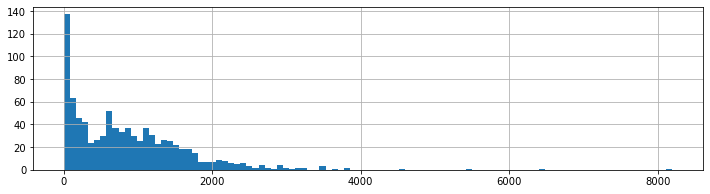

In [44]:
plt.figure(figsize = (12,3))
has_cohort_student_accesses.hist(bins=100)
plt.show()

Interesting, I want to Zoom into that dip area as I think it probably seperates full course students from those who were partials.

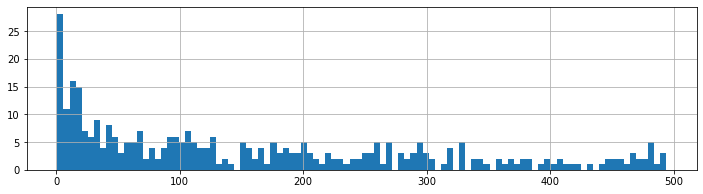

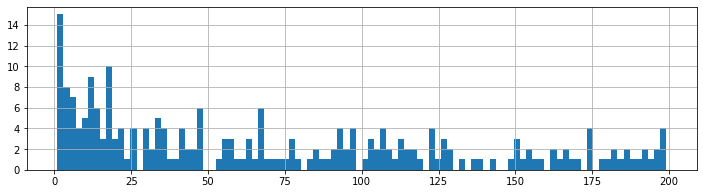

In [45]:
plt.figure(figsize = (12,3))
has_cohort_student_accesses[has_cohort_student_accesses < 500].hist(bins=100)
plt.show()
plt.figure(figsize = (12,3))
has_cohort_student_accesses[has_cohort_student_accesses < 200].hist(bins=100)
plt.show()

In [46]:
zscore = ((has_cohort_student_accesses - has_cohort_student_accesses.mean())/has_cohort_student_accesses.std())
print(has_cohort_student_accesses[zscore < -1].sort_values())

user_id
649     1
619     1
952     1
212     1
940     1
       ..
147    37
181    39
646    41
959    41
967    41
Name: date, Length: 99, dtype: int64


In [ ]:
df[df.]

#### Because the std is so large, it as well as IQR, they cannot be used to identify low outliers.  But they can be used to identify the large outliers.  Those students should be parsed into a new dataframe that can be added or removed from analysis (as inclusion may represent not normal values that raise aggregated stats higher).
1. 

Drop all paths below a certain threshold of values (indicates they are likely typos) and set them aside

# TIme series graph showing access by cohort by date in stacked bar

##### 5 - Make program_id integer and create  column with program_type (Web vs DS) *TO BE MOVED AFTER IMPUTATION*

In [ ]:
# df = df.astype({'program_id':'int8'})
# df['program_type'] = df.program_id.map({1:'Web Development',2:'Web Development',3:'Data Science'})
# df.head(5)

In [75]:
df[df.user_id == 48].unit.value_counts()

javascript-i     247
spring           185
mysql            172
java-ii          162
html-css         155
slides           133
                 115
javascript-ii    111
jquery           107
java-iii         101
java-i            62
appendix          13
search            10
mkdocs             5
toc                2
git                1
Name: unit, dtype: int64